# Imports

In [71]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [72]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset file of current TKL

In [73]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y_min_5,y_pct_5,y_mean_22,NASDAQ,Oil,NASDAQ_max_65,y_min_22,y,y_diff_10,y_std_5,y_diff_5,y_min_65,Gold,y_diff_22
4821,2025-12-05,0.970774,0.973908,-0.000253,0.95812,0.983237,0.534168,1.0,0.929787,0.973908,0.044121,0.010227,-0.000247,0.790067,0.96719,0.031696



df for visualization
----------------------


,Date,y_min_5_orig,y_pct_5_orig,y_mean_22_orig,NASDAQ_orig,Oil_orig,NASDAQ_max_65_orig,y_min_22_orig,y_orig,y_diff_10_orig,y_std_5_orig,y_diff_5_orig,y_min_65_orig,Gold_orig,y_diff_22_orig,y_next_orig
4821,2025-12-05,278.779999,-0.000251,274.296233,23578.130859,60.080002,23958.470703,266.25,278.779999,12.529999,2.90438,-0.070007,226.570358,4212.899902,9.001526,277.890015


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822 entries, 0 to 4821
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           4822 non-null   object 
 1   y_next         4822 non-null   float64
 2   y_min_5        4822 non-null   float64
 3   y_pct_5        4822 non-null   float64
 4   y_mean_22      4822 non-null   float64
 5   NASDAQ         4822 non-null   float64
 6   Oil            4822 non-null   float64
 7   NASDAQ_max_65  4822 non-null   float64
 8   y_min_22       4822 non-null   float64
 9   y              4822 non-null   float64
 10  y_diff_10      4822 non-null   float64
 11  y_std_5        4822 non-null   float64
 12  y_diff_5       4822 non-null   float64
 13  y_min_65       4822 non-null   float64
 14  Gold           4822 non-null   float64
 15  y_diff_22      4822 non-null   float64
dtypes: float64(15), object(1)
memory usage: 602.9+ KB


# LSTM

## Data prep

In [75]:
LOOK_BACK_DAYS = 66

In [76]:
#X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
#X_cols_exho = ['y', 'Gold', 'Oil', 'NASDAQ']
X_cols_tkl = ['y']
y_col =  ['y_next']

In [77]:
X, y = [], []

for i in range(LOOK_BACK_DAYS, len(df)):

    # Ensure X elements are numerical arrays
    X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)

    # Extract the scalar float value from the 1-element array
    y.append(df.loc[i, y_col].values[0])


# Explicitly cast to float32 to ensure correct dtype for Keras
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) # Reshape X for LSTM input

In [78]:
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])),
    LSTM(10),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0110
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 9.4851e-05
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 7.3586e-05
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.2473e-05
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 6.8435e-05
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 8.0497e-05
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 7.2260e-05
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 6.6001e-05
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 7.3901e-05
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.5417e-05
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 6.5145e-05
Epoch 12/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 7.5851e-05
Epoch 13/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 8.5756e-05
Epoch 14/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - l

In [80]:
pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


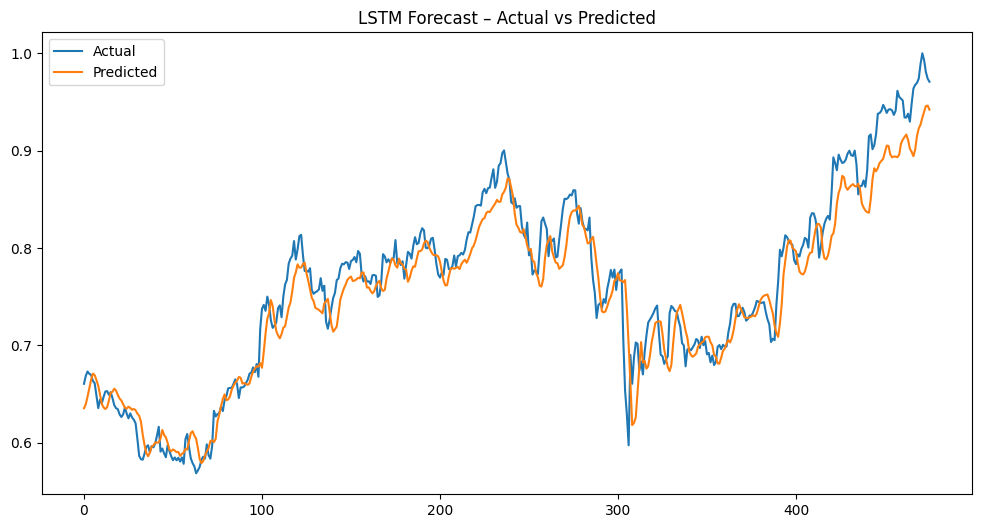

In [81]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual")
plt.plot(pred, label="Predicted")
plt.title("LSTM Forecast – Actual vs Predicted")
plt.legend()
plt.show()